# Ship data analysis example

<img align="right" src="https://movingpandas.github.io/movingpandas/assets/img/movingpandas.png">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/movingpandas/movingpandas-examples/main?filepath=2-analysis-examples/ship-data.ipynb)
[![IPYNB](https://img.shields.io/badge/view-ipynb-hotpink)](https://github.com/movingpandas/movingpandas-examples/blob/main/2-analysis-examples/ship-data.ipynb)
[![HTML](https://img.shields.io/badge/view-html-green)](https://movingpandas.github.io/movingpandas-website/2-analysis-examples/ship-data.html)

This tutorial uses AIS data published by the Danish Maritime Authority. The AIS record sample extracted for this tutorial covers vessel traffic on the 5th July 2017 near Gothenburg.

This tutorial covers: 
1. Trajectory data preprocessing
   * Loading movement data from common geospatial file formats 
   * Exploring spatial & non-spatial data distributions 
   * Applying filters to extract relevant data
   * Converting GeoDataFrames into Trajectories describing continuous tracks of moving objects
1. Trajectory analysis
   * Visualizing trajectories and their properties
   * Filtering trajectories by area of interest
   * Splitting continuous tracks into individual trips
   * Exploring trip properties including: origins, destinations, and attributes 

In [17]:
!pip install movingpandas
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt

from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve

import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.9.18 (main, Sep 11 2023, 08:38:23)  [Clang 14.0.6 ]
executable : /opt/anaconda3/bin/python
machine    : macOS-10.16-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /opt/anaconda3/lib/python3.9/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /opt/anaconda3/lib/python3.9/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.8.1
pandas     : 2.1.4
fiona      : 1.9.4.post1
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.8.4
mapclassify: None
geopy      : 2.4.1
holoviews  : 1.18.3
hvplot     : 0.10.0
geoviews   : 1.12.0
stonesoup  : None


## Loading sample AIS data 


In [18]:
%%time
df = read_file('ais.gpkg')
print(f"Finished reading {len(df)}")

Finished reading 84702
CPU times: user 9.97 s, sys: 113 ms, total: 10.1 s
Wall time: 10.1 s


Let's see what the data looks like:

In [19]:
df.head()

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry
0,05/07/2017 00:00:03,219632000,Under way using engine,0.0,270.4,NaN,Undefined,POINT (11.85958 57.68817)
1,05/07/2017 00:00:05,265650970,Under way using engine,0.0,0.5,NaN,Undefined,POINT (11.84175 57.66150)
2,05/07/2017 00:00:06,265503900,Under way using engine,0.0,0.0,NaN,Undefined,POINT (11.90650 57.69077)
3,05/07/2017 00:00:14,219632000,Under way using engine,0.0,188.4,NaN,Undefined,POINT (11.85958 57.68817)
4,05/07/2017 00:00:19,265519650,Under way using engine,0.0,357.2,NaN,Undefined,POINT (11.87192 57.68233)


<Axes: >

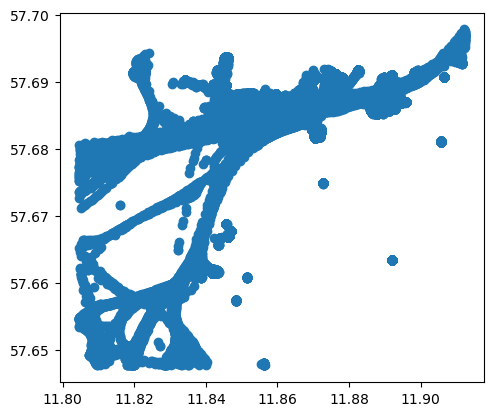

In [20]:
df.plot()

If we look at the data distributions, we can see that there are a lot of records with speed over ground (SOG) values of zero in this dataframe:

<Axes: >

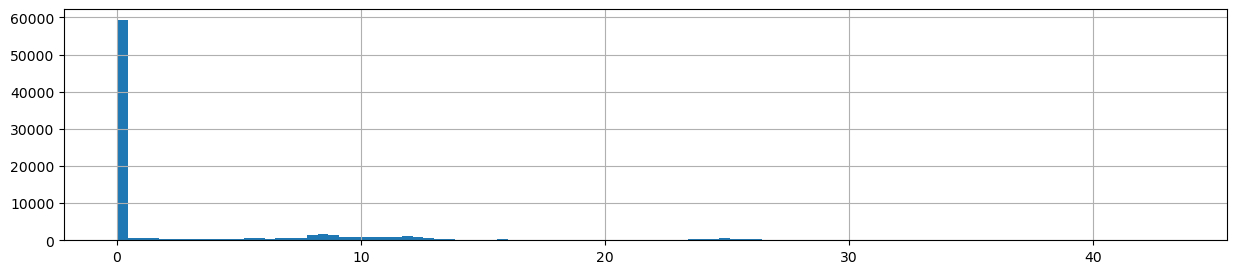

In [21]:
df['SOG'].hist(bins=100, figsize=(15,3))

Let's get rid of these rows with zero SOG:

Original size: 84702 rows
Reduced to 33593 rows after removing 0 speed records


<Axes: >

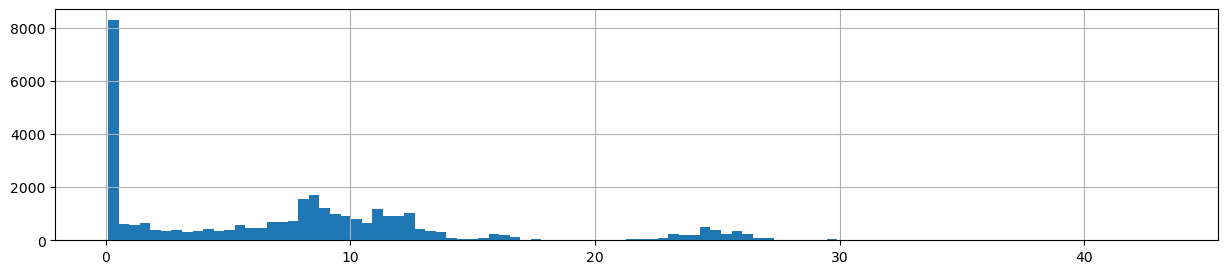

In [22]:
print(f"Original size: {len(df)} rows")
df = df[df.SOG>0]
print(f"Reduced to {len(df)} rows after removing 0 speed records")
df['SOG'].hist(bins=100, figsize=(15,3))

Let's see what kind of ships we have in our dataset:

<Axes: xlabel='ShipType'>

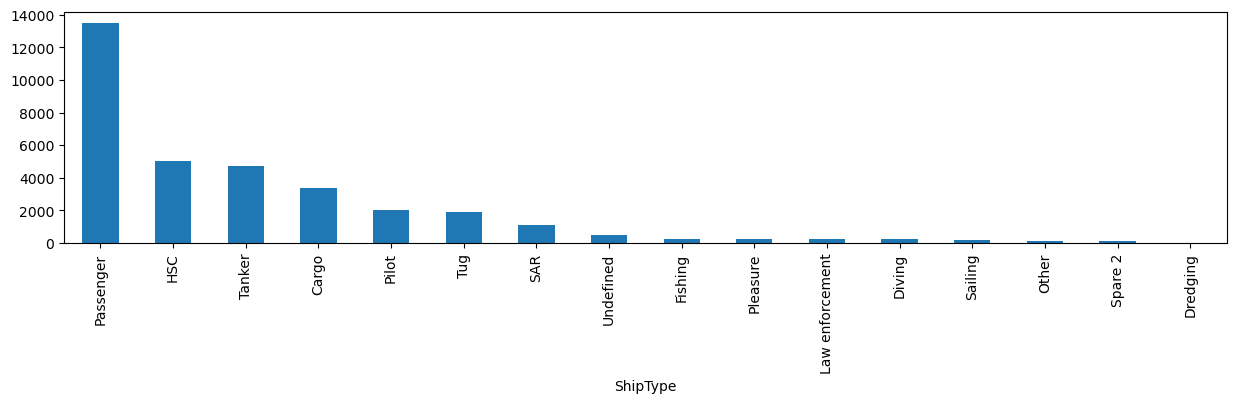

In [23]:
df['ShipType'].value_counts().plot(kind='bar', figsize=(15,3))

Finally, let's create trajectories:

In [24]:
%%time
df['t'] = pd.to_datetime(df['Timestamp'], format='%d/%m/%Y %H:%M:%S')
traj_collection = mpd.TrajectoryCollection(df, 'MMSI', t='t', min_length=2)
print(f"Finished creating {len(traj_collection)} trajectories")

Finished creating 86 trajectories
CPU times: user 2.77 s, sys: 7.89 ms, total: 2.77 s
Wall time: 2.78 s


In [27]:
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(tolerance=timedelta(minutes=1))
print(traj_collection)

TrajectoryCollection with 86 trajectories


## Plotting trajectories

Let's give the most common ship types distinct colors. The remaining ones will be just grey:

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

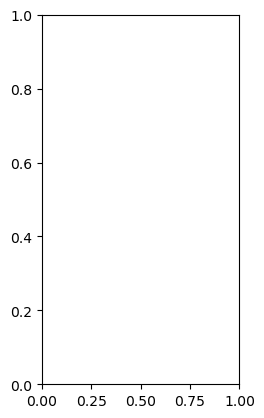

In [28]:
shiptype_to_color = {'Passenger': 'blue', 'HSC': 'green', 'Tanker': 'red', 'Cargo': 'orange', 'Sailing': 'grey', 'Other': 'grey', 
                     'Tug': 'grey', 'SAR': 'grey', 'Undefined': 'grey', 'Pleasure': 'grey', 'Dredging': 'grey', 'Law enforcement': 'grey',
                    'Pilot': 'grey', 'Fishing': 'grey', 'Diving':'grey', 'Spare 2': 'grey'}
traj_collection.plot(column='ShipType', column_to_color=shiptype_to_color, linewidth=1, capstyle='round')

In [29]:
!pip install cartopy
!pip install geoviews
import cartopy, geoviews
passenger = traj_collection.filter('ShipType', 'Passenger')
passenger.hvplot(title='Passenger ferries', line_width=2, frame_width=700, frame_height=500)
mpd.show_versions()


MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.9.18 (main, Sep 11 2023, 08:38:23)  [Clang 14.0.6 ]
executable : /opt/anaconda3/bin/python
machine    : macOS-10.16-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.6.4
GDAL data dir: /opt/anaconda3/lib/python3.9/site-packages/fiona/gdal_data
PROJ       : 9.2.1
PROJ data dir: /opt/anaconda3/lib/python3.9/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.8.1
pandas     : 2.1.4
fiona      : 1.9.4.post1
numpy      : 1.24.3
shapely    : 2.0.1
rtree      : 1.0.1
pyproj     : 3.6.0
matplotlib : 3.8.4
mapclassify: None
geopy      : 2.4.1
holoviews  : 1.18.3
hvplot     : 0.10.0
geoviews   : 1.12.0
stonesoup  : None


## Visualizing trajectory properties

We can also plot individual trajectories to better visualize their properties, such as the changes in NavStatus:

In [30]:
my_traj = traj_collection.trajectories[0]
my_traj.df.head()

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry
t,,,,,,,,
2017-07-05 17:32:18,05/07/2017 17:32:18,210035000,Under way using engine,9.8,52.8,NORDIC HAMBURG,Cargo,POINT (11.80462 57.67612)
2017-07-05 17:33:18,05/07/2017 17:33:18,210035000,Under way using engine,9.5,58.9,NORDIC HAMBURG,Cargo,POINT (11.80875 57.67773)
2017-07-05 17:34:18,05/07/2017 17:34:18,210035000,Under way using engine,9.3,70.5,NORDIC HAMBURG,Cargo,POINT (11.81311 57.67879)
2017-07-05 17:35:28,05/07/2017 17:35:28,210035000,Under way using engine,9.5,71.1,NORDIC HAMBURG,Cargo,POINT (11.81855 57.67968)
2017-07-05 17:36:28,05/07/2017 17:36:28,210035000,Under way using engine,9.4,71.3,NORDIC HAMBURG,Cargo,POINT (11.82334 57.68044)


In [31]:
my_traj.df.tail()

,Timestamp,MMSI,NavStatus,SOG,COG,Name,ShipType,geometry
t,,,,,,,,
2017-07-05 22:47:34,05/07/2017 22:47:34,210035000,Moored,0.1,276.0,NORDIC HAMBURG,Cargo,POINT (11.84571 57.68958)
2017-07-05 23:08:44,05/07/2017 23:08:44,210035000,Moored,0.1,96.0,NORDIC HAMBURG,Cargo,POINT (11.84571 57.68958)
2017-07-05 23:09:54,05/07/2017 23:09:54,210035000,Moored,0.1,96.0,NORDIC HAMBURG,Cargo,POINT (11.84571 57.68958)
2017-07-05 23:11:45,05/07/2017 23:11:45,210035000,Moored,0.1,96.0,NORDIC HAMBURG,Cargo,POINT (11.84571 57.68958)
2017-07-05 23:35:58,05/07/2017 23:35:58,210035000,Moored,0.1,276.0,NORDIC HAMBURG,Cargo,POINT (11.84571 57.68958)


In [33]:
my_traj.hvplot(title=f'Trajectory {my_traj.id}', frame_width=800, frame_height=500, line_width=5.0, c='NavStatus', cmap='Dark2') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (NavStatus)
   .Points.I :Points   [Longitude,Latitude]   (NavStatus,triangle_angle)

## Finding ships passing under Älvsborgsbron bridge
We can find ships passing under the bridge based on trajectory intersections with the bridge area.

In [ ]:
area_of_interest = Polygon([(11.89935, 57.69270), (11.90161, 57.68902), (11.90334, 57.68967), (11.90104, 57.69354), (11.89935, 57.69270)])

In [ ]:
intersecting = traj_collection.get_intersecting(area_of_interest)
print(f"Found {len(intersecting)} intersections")

In [ ]:
bridge_traj = intersecting.trajectories[0]
bridge_traj.hvplot(title=f'Trajectory {bridge_traj.id}', frame_width=700, frame_height=500, line_width=5.0, c='NavStatus', cmap='Dark2') 

In [ ]:
bridge_traj.df.head()

## Identifying trip origins and destinations

Since AIS records with a speed over ground (SOG) value of zero have been removed from the dataset, we can use the `split_by_observation_gap()` function to split the continuous observations into individual trips:

In [ ]:
trips = mpd.ObservationGapSplitter(passenger).split(gap=timedelta(minutes=5))
print(f"Extracted {len(trips)} individual trips from {len(passenger)} continuous vessel tracks")

Let's plot the resulting trips!

In [ ]:
trips.hvplot(title='Passenger ferry trips', line_width=2, frame_width=700, frame_height=500)

Compared to plotting the original continuous observations, this visualization is much cleaner because there are no artifacts at the border of the area of interest. 

Next, let's get the trip origins:

In [ ]:
origins = trips.get_start_locations()
origins.hvplot(title='Trip origins by ship type', c='Name', geo=True, tiles='OSM', frame_width=700, frame_height=500)

In our data sample, trip origins can be:
- When a ship departs its anchoring location and the speed changes from 0 to >0
- When a ship trajectory first enters the observation area

In [ ]:
origins.hvplot(title='Origins by speed', c='SOG', geo=True, tiles='OSM', frame_width=700, frame_height=500)

## Finding ships that depart from Sjöfartsverket (Maritime Administration)

In [ ]:
trips = mpd.ObservationGapSplitter(traj_collection).split(gap=timedelta(minutes=5))
area_of_interest = Polygon([(11.86815, 57.68273), (11.86992, 57.68047), (11.87419, 57.68140), (11.87288, 57.68348), (11.86815, 57.68273)])

We can identify vessels that start their trip within a given area of interest by intersecting trip starting locations with our area of interest:

In [ ]:
departures = [traj for traj in trips if traj.get_start_location().intersects(area_of_interest) and traj.get_length() > 100]       
print(f"Found {len(departures)} departures")

In [ ]:
tc = mpd.TrajectoryCollection(departures)
tc.hvplot(title=f'Ships departing from Sjöfartsverket', line_width=3, frame_width=700, frame_height=500, hover_cols=['Name']) 

Let's see what kind of ships depart from here:

In [ ]:
for traj in departures:
    print(f"{traj.df['ShipType'].iloc[0]} vessel '{traj.df['Name'].iloc[0]}' departed at {traj.get_start_time()}")

Of course, the same works for arrivals:

In [ ]:
arrivals = [traj for traj in trips if traj.get_end_location().intersects(area_of_interest) and traj.get_length() > 100]
print(f"Found {len(arrivals)} arrivals")

for traj in arrivals:
    print(f"{traj.df['ShipType'].iloc[0]} vessel '{traj.df['Name'].iloc[0]}' arrived at {traj.get_end_time()}")

In [ ]:
tc = mpd.TrajectoryCollection(arrivals)
tc.hvplot(title=f'Ships arriving in Sjöfartsverket', line_width=3, frame_width=700, frame_height=500, hover_cols=['Name']) 

## Clustering origins

To run this section, you need to have the scikit-learn package installed. 

In [ ]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [ ]:
origins = trips.get_start_locations()
origins['lat'] = origins.geometry.y
origins['lon'] = origins.geometry.x
matrix = origins[['lat','lon']].values

In [ ]:
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian

In [ ]:
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(matrix))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([matrix[cluster_labels == n] for n in range(num_clusters)])
print(f'Number of clusters: {num_clusters}')

In [ ]:
origins['cluster'] = cluster_labels

In [ ]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return Point(tuple(centermost_point)[1], tuple(centermost_point)[0])
centermost_points = clusters.map(get_centermost_point)

In [ ]:
origins.hvplot(title='Clustered origins', c='cluster', geo=True, tiles='OSM', cmap='glasbey_dark', frame_width=700, frame_height=500)

In [ ]:
origins_by_cluster = pd.DataFrame(origins).groupby(['cluster'])
summary = origins_by_cluster['ShipType'].unique().to_frame(name='types')
summary['n'] = origins_by_cluster.size()
summary['sog'] = origins_by_cluster['SOG'].mean()
summary['geometry'] = centermost_points
summary = summary[summary['n']>1].sort_values(by='n', ascending=False)
summary.head()

In [ ]:
cluster_of_interest_id = 28
origins[origins['cluster']==cluster_of_interest_id].hvplot(
    title=f'Cluster {cluster_of_interest_id}', c='ShipType', geo=True, tiles='OSM', frame_width=700, frame_height=500)

In [ ]:
( trips.hvplot(title='Origin clusters by speed', color='gray', line_width=1, frame_width=700, frame_height=500) *
  GeoDataFrame(summary, crs=4326).hvplot(c='sog', size=np.sqrt(dim('n'))*3, geo=True,  cmap='RdYlGn')
)

## Continue exploring MovingPandas

1. [Bird migration analysis](bird-migration.ipynb)
1. [Ship data analysis](ship-data.ipynb)
1. [Horse collar data exploration](horse-collar.ipynb)
1. [OSM traces](osm-traces.ipynb)
1. [Soccer game](soccer-game.ipynb)
1. [Mars rover & heli](mars-rover.ipynb)